Transfer Learning with a CNN


### GPU connection Check

In [138]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 29 03:03:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   75C    P0              36W /  72W |    595MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Import Libraries

In [207]:
# Core PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

# Additional libraries
import numpy as np
import os
import time
from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import shutil

# torchvision imports
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder




%matplotlib inline

cudnn.benchmark = True
plt.ion()   # interactive mode

### Check memory availability

In [140]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


### Import Data

In [155]:
# !git clone https://github.com/sgeinitz/CS3120.git
!git clone https://github.com/jyassien/LPDI.git

fatal: destination path 'LPDI' already exists and is not an empty directory.


## Load Model

In [156]:
model = models.resnet18(pretrained=True)

num_classes = 8  # 8 variant classififcations of plants
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Allocate GPU for the model

In [187]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# print out which device is being used
print(f"Using device: {device}")

Using device: cuda


Load Data
=========


In [194]:
# Data augmentation and normalization for training
# Just normalization for
from torchvision import datasets, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/LPDI/server/data/tomato/Variant_A'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


Examples of testing images:
======================

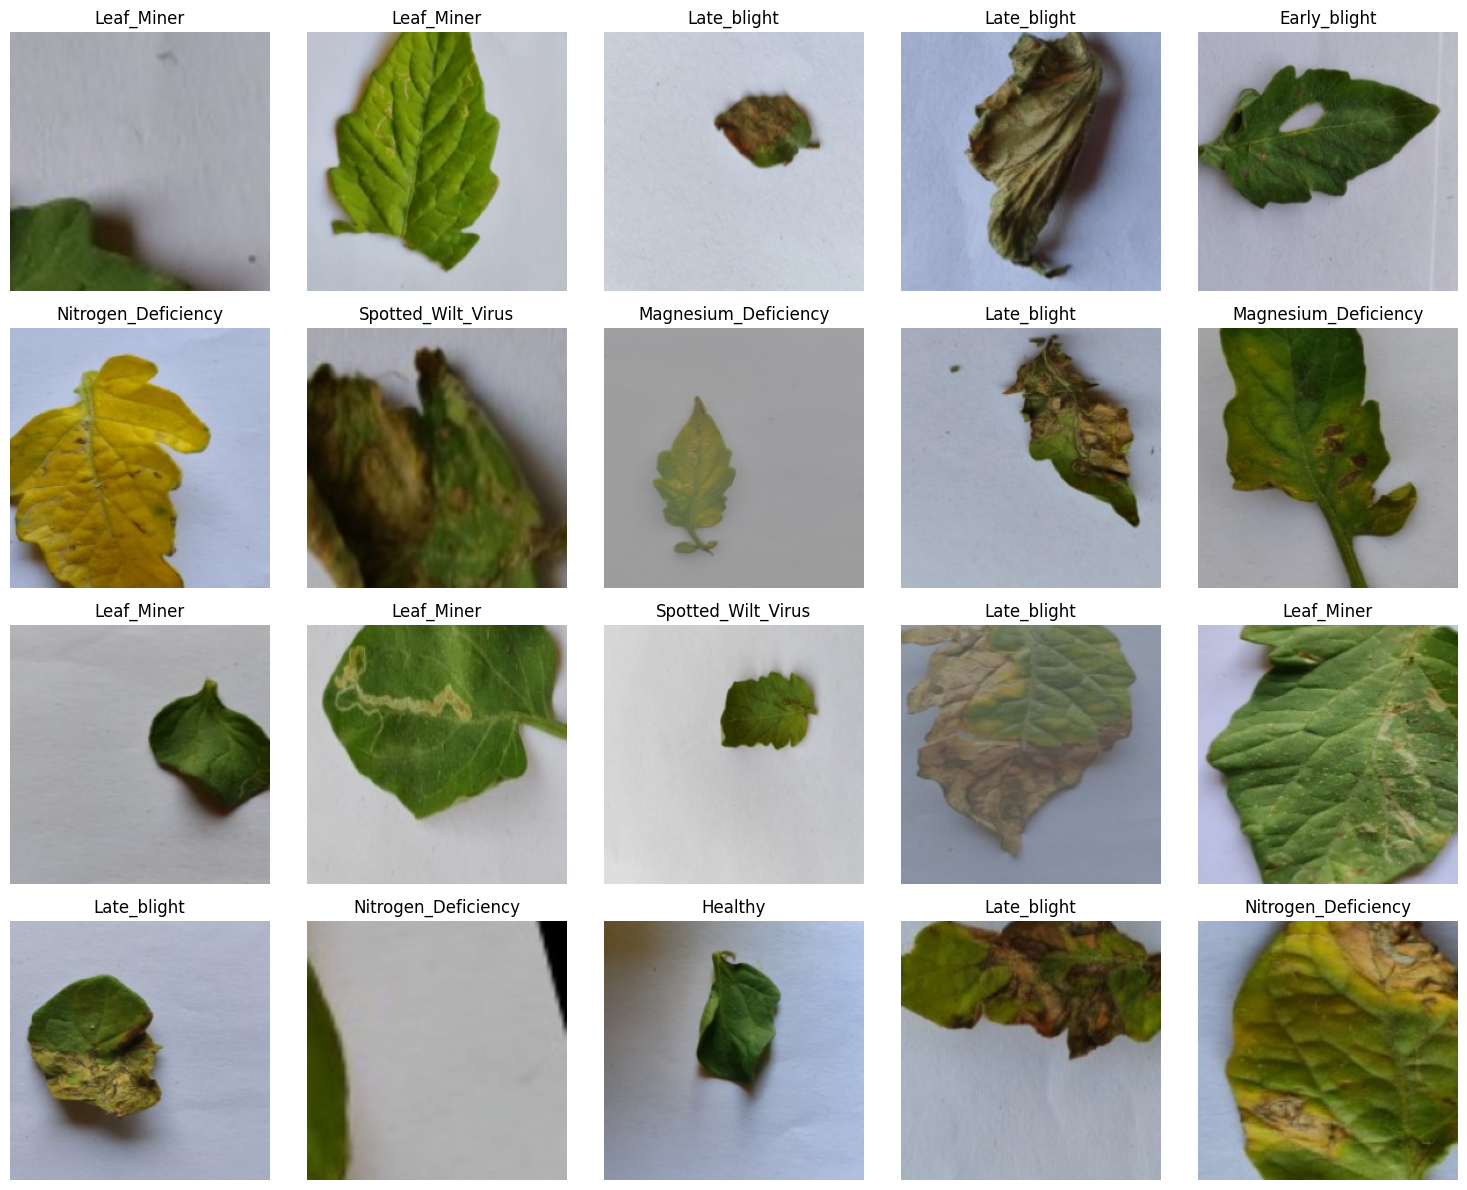

In [195]:
def imshow_grid(inputs, classes, class_names, num_rows=4):
    """Display images in a grid with class names above each image."""
    batch_size = inputs.size(0)
    inputs = inputs.cpu()  # matplotlib compatibility

    num_columns = batch_size // num_rows if batch_size % num_rows == 0 else (batch_size // num_rows) + 1

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        if idx < batch_size:
            inp = inputs[idx].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            ax.imshow(inp)
            ax.set_title(class_names[classes[idx]], fontsize=12)
            ax.axis("off")
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

training_examples = imshow_grid(inputs, classes, class_names, num_rows=4)


Perform model testing
==================

In [197]:
def test_model(model, dataloaders, dataset_sizes):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    # Compute accuracy
    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

    return accuracy


# Call the testing function and save the accuracy
accuracy = test_model(model, dataloaders, dataset_sizes)




Validation Accuracy: 7.21%


## Visualizing model *predictions*

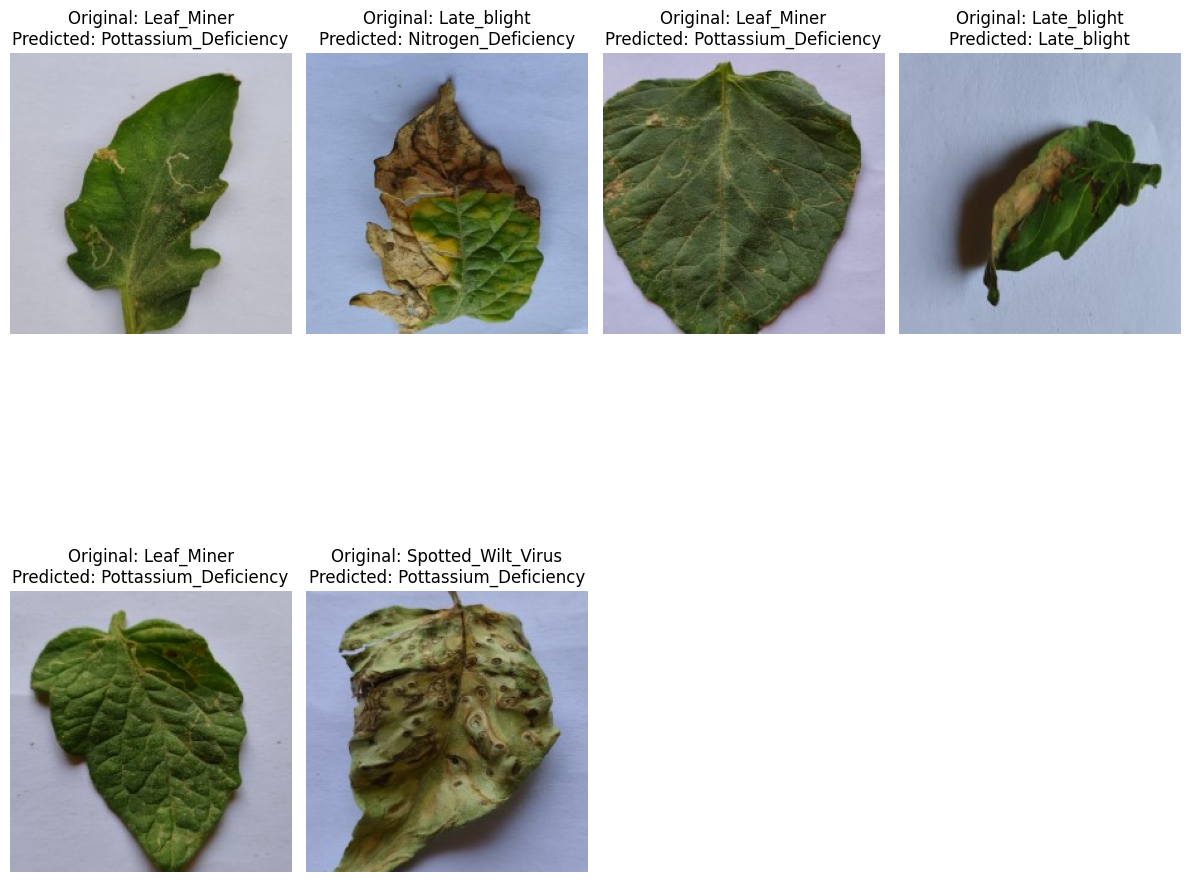

In [198]:
def imshow(inp, ax):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    ax.axis('off')


def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))  # Initialize the figure

    num_rows = (num_images + 3) // 4  # Calculate rows for grid

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            batch_size = inputs.size(0)
            for j in range(batch_size):
                # Check if the label and prediction are within the bounds of class_names
                if labels[j].item() >= len(class_names) or preds[j].item() >= len(class_names):
                    print(f"Skipping label {labels[j].item()} or prediction {preds[j].item()} as it is out of range")
                    continue  # Skip this image if it's out of bounds

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    return fig  # Ensure a valid figure is returned

                images_so_far += 1
                row = (images_so_far - 1) // 4
                col = (images_so_far - 1) % 4

                ax = plt.subplot(num_rows, 4, images_so_far)
                ax.set_title(f'Original: {class_names[labels[j]]}\nPredicted: {class_names[preds[j]]}')

                imshow(inputs.cpu().data[j], ax)

        model.train(mode=was_training)

    plt.tight_layout()
    return fig


figure = visualize_model(model, dataloaders, class_names, num_images=6)





### Save Outputs


In [217]:
folder = '/content/model_summaries'
pdf_name = f'{model.__class__.__name__}_summary.pdf'
pdf_path = os.path.join(folder, pdf_name)

# Ensure the folder exists
if not os.path.exists(folder):
    os.makedirs(folder)


def save_to_pdf(pdf, figure):
    pdf.savefig(figure)
    plt.close(figure)


def save_model_outputs_to_pdf(model, accuracy, figure):

    with PdfPages(pdf_path) as pdf:
        # Validation accuracy
        fig = plt.figure(figsize=(8, 4))
        plt.text(0.5, 0.5, f"Model: {model.__class__.__name__}\nValidation Accuracy: {accuracy:.2f}%",
                 horizontalalignment='center', verticalalignment='center', fontsize=18)
        plt.axis('off')
        save_to_pdf(pdf, fig)

        # Predictions visualization)
        save_to_pdf(pdf, figure)  # Save the figure visualizing predictions

    print(f"Model summary saved to {pdf_path}")


save_model_outputs_to_pdf(model, accuracy, figure)

Model summary saved to /content/model_summaries/ResNet_summary.pdf


# Save to GitHub




In [218]:
git_path = f'/content/LPDI/server/model/model_summaries/{pdf_name}'
shutil.copy(pdf_path, git_path)

%cd /content/LPDI



/content/LPDI
